<a href="https://colab.research.google.com/github/eugeniapramesti/Sentiment-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import re

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/nlp/Restaurant_Reviews.tsv', sep ='\t')
# Keeping only the neccessary columns
data = data[['Review','Liked']]

In [ ]:
print(data)
print()
print(data.shape)
print()
print(data.isnull().sum())

                                                Review  Liked
0                             Wow... Loved this place.      1
1                                   Crust is not good.      0
2            Not tasty and the texture was just nasty.      0
3    Stopped by during the late May bank holiday of...      1
4    The selection on the menu was great and so wer...      1
..                                                 ...    ...
995  I think food should have flavor and texture an...      0
996                           Appetite instantly gone.      0
997  Overall I was not impressed and would not go b...      0
998  The whole experience was underwhelming, and I ...      0
999  Then, as if I hadn't wasted enough of my life ...      0

[1000 rows x 2 columns]

(1000, 2)

Review    0
Liked     0
dtype: int64


In [ ]:
data['Review'] = data['Review'].apply(lambda x: x.lower())
data['Review'] = data['Review'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['Liked'] == 1].size)
print(data[ data['Liked'] == 0].size)

max_features = 300
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['Review'].values)
X = tokenizer.texts_to_sequences(data['Review'].values)
X = pad_sequences(X)

1000
1000


In [ ]:
embed_dim = 32
lstm_out = 32

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 26, 32)            9600      
                                                                 
 spatial_dropout1d_11 (Spati  (None, 26, 32)           0         
 alDropout1D)                                                    
                                                                 
 lstm_11 (LSTM)              (None, 32)                8320      
                                                                 
 dense_11 (Dense)            (None, 2)                 66        
                                                                 
Total params: 17,986
Trainable params: 17,986
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
Y = pd.get_dummies(data['Liked']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(700, 26) (700, 2)
(300, 26) (300, 2)


In [ ]:
validation_size = len(X_test) // 2

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]

In [ ]:
batch_size = 32
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

model.fit(X_train, Y_train, epochs = 20, batch_size=batch_size, verbose = 2, validation_data=(X_validate, Y_validate), callbacks=[early_stopping])

Epoch 1/20
22/22 - 5s - loss: 0.6934 - accuracy: 0.5129 - val_loss: 0.6922 - val_accuracy: 0.4733 - 5s/epoch - 221ms/step
Epoch 2/20
22/22 - 1s - loss: 0.6879 - accuracy: 0.5914 - val_loss: 0.6878 - val_accuracy: 0.5267 - 796ms/epoch - 36ms/step
Epoch 3/20
22/22 - 1s - loss: 0.6772 - accuracy: 0.6743 - val_loss: 0.6748 - val_accuracy: 0.6133 - 1s/epoch - 58ms/step
Epoch 4/20
22/22 - 1s - loss: 0.6495 - accuracy: 0.6871 - val_loss: 0.6273 - val_accuracy: 0.7067 - 1s/epoch - 62ms/step
Epoch 5/20
22/22 - 1s - loss: 0.5852 - accuracy: 0.7186 - val_loss: 0.5520 - val_accuracy: 0.7267 - 1s/epoch - 62ms/step
Epoch 6/20
22/22 - 1s - loss: 0.5030 - accuracy: 0.7929 - val_loss: 0.4526 - val_accuracy: 0.8333 - 1s/epoch - 53ms/step
Epoch 7/20
22/22 - 1s - loss: 0.4389 - accuracy: 0.8171 - val_loss: 0.4009 - val_accuracy: 0.8267 - 795ms/epoch - 36ms/step
Epoch 8/20
22/22 - 1s - loss: 0.4133 - accuracy: 0.8129 - val_loss: 0.3791 - val_accuracy: 0.8333 - 780ms/epoch - 35ms/step
Epoch 9/20
22/22 - 1s 

In [ ]:
# validation_size = len(X_test) // 2

# X_validate = X_test[-validation_size:]
# Y_validate = Y_test[-validation_size:]
# X_test = X_test[:-validation_size]
# Y_test = Y_test[:-validation_size]

score, acc = model.evaluate(X_test, Y_test, verbose=2, batch_size=batch_size)
print("score: %.2f" % score)
print("acc: %.2f" % acc)

5/5 - 0s - loss: 0.5757 - accuracy: 0.7733 - 52ms/epoch - 10ms/step
score: 0.58
acc: 0.77


In [ ]:
# Calculate the predicted labels for the test data
Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)  # Convert probabilities to class labels
Y_test = np.argmax(Y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate precision, recall, and F1 score
report = classification_report(Y_test, Y_pred)
print("Classification Report:")
print(report)

5/5 [==============================] - 0s 9ms/step
Confusion Matrix:
[[63  8]
 [26 53]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.89      0.79        71
           1       0.87      0.67      0.76        79

    accuracy                           0.77       150
   macro avg       0.79      0.78      0.77       150
weighted avg       0.79      0.77      0.77       150



In [ ]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):

    result = model.predict(X_validate[x].reshape(1,X_validate.shape[1]),batch_size=1,verbose = 2)[0]

    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1

    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 28m

In [ ]:
text = ['the food is good']
#vectorizing the tweet by the pre-fitted tokenizer instance
text = tokenizer.texts_to_sequences(text)
#padding the tweet to have exactly the same shape as `embedding_2` input
text = pad_sequences(text, maxlen=28, dtype='int32', value=0)
print(text)
sentiment = model.predict(text,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   1 11  7 16]]
1/1 - 0s - 457ms/epoch - 457ms/step
positive


In [ ]:
text = ['the food is very bad']
#vectorizing the tweet by the pre-fitted tokenizer instance
text = tokenizer.texts_to_sequences(text)
#padding the tweet to have exactly the same shape as `embedding_2` input
text = pad_sequences(text, maxlen=28, dtype='int32', value=0)
print(text)
sentiment = model.predict(text,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
  11  7 19 95]]
1/1 - 0s - 33ms/epoch - 33ms/step
negative


In [ ]:
text = ['both the egg and fish were fantastic.']
#vectorizing the tweet by the pre-fitted tokenizer instance
text = tokenizer.texts_to_sequences(text)
#padding the tweet to have exactly the same shape as `embedding_2` input
text = pad_sequences(text, maxlen=28, dtype='int32', value=0)
print(text)
sentiment = model.predict(text,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0 214   1   2  27 146]]
1/1 - 0s - 26ms/epoch - 26ms/step
positive


In [ ]:
text = ['The worst food i have ever eaten']
#vectorizing the tweet by the pre-fitted tokenizer instance
text = tokenizer.texts_to_sequences(text)
#padding the tweet to have exactly the same shape as `embedding_2` input
text = pad_sequences(text, maxlen=28, dtype='int32', value=0)
print(text)
sentiment = model.predict(text,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   1 123  11   3  30  52]]
1/1 - 0s - 23ms/epoch - 23ms/step
negative


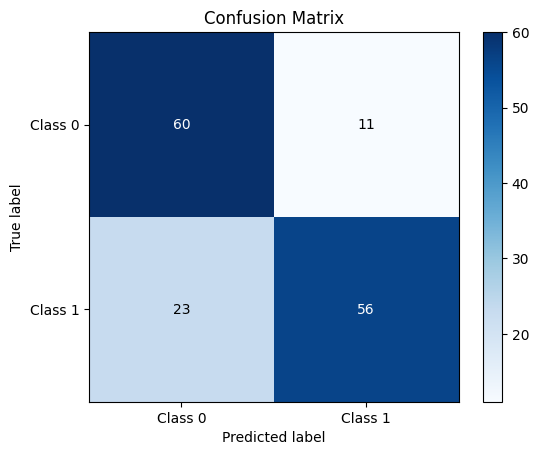

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define the confusion matrix values
cm = np.array([[60, 11], [23, 56]])

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the confusion matrix
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set labels, title, and ticks
classes = ['Class 0', 'Class 1']
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Loop over the data and add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

# Show the plot
plt.show()